In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1️⃣ 라이브러리 확인 및 설치

In [15]:
import sys
print(f"Python 버전: {sys.version}")

try:
    import torch
    print(f"✓ PyTorch 버전: {torch.__version__}")
    print(f"✓ CUDA 사용 가능: {torch.cuda.is_available()}")
except ImportError:
    print("PyTorch를 설치합니다...")
    !pip install torch

import numpy as np
import matplotlib.pyplot as plt
print("\n모든 라이브러리 준비 완료! ✨")

Python 버전: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
✓ PyTorch 버전: 2.9.0+cu126
✓ CUDA 사용 가능: True

모든 라이브러리 준비 완료! ✨


## 2️⃣ 데이터셋 업로드

왼쪽 파일 탭에서 `dataset.txt` 파일을 업로드하세요.

In [16]:
import os

if os.path.exists('/dataset.txt'):
    print("dataset.txt 파일이 있습니다!")
    with open('/dataset.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()
    print(f"✓ 총 {len(lines)}개의 문장 쌍이 있습니다.")
    print("\n처음 3개 샘플:")
    for i, line in enumerate(lines[:3]):
        print(f"{i+1}. {line.strip()}")
else:
    print("dataset.txt 파일을 업로드해주세요!")
    print("   왼쪽 파일 탭 > 업로드 버튼 클릭")

✓ dataset.txt 파일이 있습니다!
✓ 총 102개의 문장 쌍이 있습니다.

처음 3개 샘플:
1. Hello|안녕하세요
2. Good morning|좋은 아침입니다
3. Thank you|감사합니다


## 3️⃣ 데이터 전처리 코드

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class Tokenizer:
    """간단한 단어 기반 토크나이저"""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.vocab_size = 0

        # 특수 토큰
        self.PAD_TOKEN = '<PAD>'
        self.SOS_TOKEN = '<SOS>'
        self.EOS_TOKEN = '<EOS>'
        self.UNK_TOKEN = '<UNK>'

    def build_vocab(self, sentences):
        """문장 리스트로부터 어휘 사전 생성"""
        all_words = []
        for sentence in sentences:
            words = self._tokenize(sentence)
            all_words.extend(words)

        word_counts = Counter(all_words)

        self.word2idx = {
            self.PAD_TOKEN: 0,
            self.SOS_TOKEN: 1,
            self.EOS_TOKEN: 2,
            self.UNK_TOKEN: 3
        }

        idx = 4
        for word, _ in word_counts.most_common():
            self.word2idx[word] = idx
            idx += 1

        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)

        print(f"어휘 사전 크기: {self.vocab_size}")

    def _tokenize(self, text):
        """텍스트를 토큰으로 분리"""
        text = text.lower()
        tokens = text.split()
        return tokens

    def encode(self, text):
        """텍스트를 인덱스 시퀀스로 변환"""
        tokens = self._tokenize(text)
        indices = [self.word2idx.get(token, self.word2idx[self.UNK_TOKEN])
                   for token in tokens]
        return indices

    def decode(self, indices):
        """인덱스 시퀀스를 텍스트로 변환"""
        tokens = [self.idx2word.get(idx, self.UNK_TOKEN) for idx in indices]
        tokens = [t for t in tokens if t not in [self.PAD_TOKEN, self.SOS_TOKEN, self.EOS_TOKEN]]
        return ' '.join(tokens)


class TranslationDataset(Dataset):
    """번역 데이터셋 클래스"""
    def __init__(self, src_sentences, tgt_sentences, src_tokenizer, tgt_tokenizer, max_len=50):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src_text = self.src_sentences[idx]
        tgt_text = self.tgt_sentences[idx]

        src_indices = self.src_tokenizer.encode(src_text)
        tgt_indices = self.tgt_tokenizer.encode(tgt_text)

        tgt_indices = [self.tgt_tokenizer.word2idx[self.tgt_tokenizer.SOS_TOKEN]] + \
                      tgt_indices + \
                      [self.tgt_tokenizer.word2idx[self.tgt_tokenizer.EOS_TOKEN]]

        src_indices = self._pad_sequence(src_indices, self.src_tokenizer.word2idx[self.src_tokenizer.PAD_TOKEN])
        tgt_indices = self._pad_sequence(tgt_indices, self.tgt_tokenizer.word2idx[self.tgt_tokenizer.PAD_TOKEN])

        return torch.tensor(src_indices), torch.tensor(tgt_indices)

    def _pad_sequence(self, seq, pad_idx):
        if len(seq) > self.max_len:
            return seq[:self.max_len]
        else:
            return seq + [pad_idx] * (self.max_len - len(seq))


def load_data(file_path):
    """데이터 파일 로딩"""
    src_sentences = []
    tgt_sentences = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if '|' in line:
                src, tgt = line.split('|')
                src_sentences.append(src.strip())
                tgt_sentences.append(tgt.strip())

    print(f"데이터셋 크기: {len(src_sentences)}개 문장 쌍")
    return src_sentences, tgt_sentences


def prepare_dataloaders(file_path, batch_size=8, max_len=50, train_ratio=0.8):
    """데이터 로더 준비"""
    src_sentences, tgt_sentences = load_data(file_path)

    src_tokenizer = Tokenizer()
    tgt_tokenizer = Tokenizer()

    src_tokenizer.build_vocab(src_sentences)
    tgt_tokenizer.build_vocab(tgt_sentences)

    train_size = int(len(src_sentences) * train_ratio)

    train_src = src_sentences[:train_size]
    train_tgt = tgt_sentences[:train_size]
    val_src = src_sentences[train_size:]
    val_tgt = tgt_sentences[train_size:]

    train_dataset = TranslationDataset(train_src, train_tgt, src_tokenizer, tgt_tokenizer, max_len)
    val_dataset = TranslationDataset(val_src, val_tgt, src_tokenizer, tgt_tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print(f"학습 데이터: {len(train_dataset)}개")
    print(f"검증 데이터: {len(val_dataset)}개")

    return train_loader, val_loader, src_tokenizer, tgt_tokenizer

print("✓ 데이터 전처리 코드 로드 완료")

✓ 데이터 전처리 코드 로드 완료


## 4️⃣ Transformer 모델 구현

In [18]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    """위치 인코딩"""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x


class MultiHeadAttention(nn.Module):
    """Multi-Head Attention"""
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1))
        scores = scores / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)

        return output

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)

        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(attn_output)

        return output


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        cross_attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x


class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=128, num_heads=4,
                 num_encoder_layers=2, num_decoder_layers=2, d_ff=256,
                 max_len=50, dropout=0.1, pad_idx=0):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.pad_idx = pad_idx

        self.src_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx=pad_idx)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx=pad_idx)
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])

        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def make_src_mask(self, src):
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_tgt_mask(self, tgt):
        tgt_len = tgt.size(1)
        tgt_pad_mask = (tgt != self.pad_idx).unsqueeze(1).unsqueeze(2)
        tgt_sub_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
        tgt_mask = tgt_pad_mask & tgt_sub_mask
        return tgt_mask

    def encode(self, src, src_mask):
        x = self.src_embedding(src) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.encoder_layers:
            x = layer(x, src_mask)

        return x

    def decode(self, tgt, enc_output, src_mask, tgt_mask):
        x = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.decoder_layers:
            x = layer(x, enc_output, src_mask, tgt_mask)

        return x

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        enc_output = self.encode(src, src_mask)
        dec_output = self.decode(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc_out(dec_output)

        return output

print("Transformer 모델 코드 로드 완료")

✓ Transformer 모델 코드 로드 완료


## 5️⃣ 학습 함수 정의

In [19]:
import torch.optim as optim

def train_epoch(model, dataloader, optimizer, criterion, device):
    """한 에포크 학습"""
    model.train()
    total_loss = 0

    for batch_idx, (src, tgt) in enumerate(dataloader):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        tgt_output = tgt_output.contiguous().view(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    """모델 평가"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src = src.to(device)
            tgt = tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            tgt_output = tgt_output.contiguous().view(-1)

            loss = criterion(output, tgt_output)
            total_loss += loss.item()

    return total_loss / len(dataloader)

print("학습 함수 로드 완료")

✓ 학습 함수 로드 완료


## 6️⃣ 학습 실행

이제 모델을 학습시킵니다! (약 5~10분 소요)

In [21]:
# 하이퍼파라미터 설정
BATCH_SIZE = 8
D_MODEL = 128
NUM_HEADS = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
D_FF = 256
DROPOUT = 0.1
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50
MAX_LEN = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\n데이터 준비 중...")
train_loader, val_loader, src_tokenizer, tgt_tokenizer = prepare_dataloaders(
    '/dataset.txt',
    batch_size=BATCH_SIZE,
    max_len=MAX_LEN,
    train_ratio=0.8
)

# 모델 생성
print("\n모델 생성 중...")
model = Transformer(
    src_vocab_size=src_tokenizer.vocab_size,
    tgt_vocab_size=tgt_tokenizer.vocab_size,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    d_ff=D_FF,
    max_len=MAX_LEN,
    dropout=DROPOUT,
    pad_idx=tgt_tokenizer.word2idx[tgt_tokenizer.PAD_TOKEN]
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"학습 가능한 파라미터 수: {num_params:,}")

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=tgt_tokenizer.word2idx[tgt_tokenizer.PAD_TOKEN])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\n학습 시작 (총 {NUM_EPOCHS} 에포크)...")
print("=" * 70)

사용 디바이스: cuda
GPU: Tesla T4

데이터 준비 중...
데이터셋 크기: 102개 문장 쌍
어휘 사전 크기: 179
어휘 사전 크기: 176
학습 데이터: 81개
검증 데이터: 21개

모델 생성 중...
학습 가능한 파라미터 수: 730,672

학습 시작 (총 50 에포크)...


In [22]:
# 학습 루프
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 70)

    # 학습
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    # 검증
    val_loss = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # 베스트 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"✓ 베스트 모델 (Val Loss: {best_val_loss:.4f})")

print("\n" + "=" * 70)
print("학습 완료!")
print(f"최종 Train Loss: {train_losses[-1]:.4f}")
print(f"최종 Val Loss: {val_losses[-1]:.4f}")
print(f"최고 Val Loss: {best_val_loss:.4f}")


Epoch 1/50
----------------------------------------------------------------------
Train Loss: 5.0573 | Val Loss: 4.7933
✓ 베스트 모델 (Val Loss: 4.7933)

Epoch 2/50
----------------------------------------------------------------------
Train Loss: 4.4640 | Val Loss: 4.3371
✓ 베스트 모델 (Val Loss: 4.3371)

Epoch 3/50
----------------------------------------------------------------------
Train Loss: 3.9949 | Val Loss: 4.1327
✓ 베스트 모델 (Val Loss: 4.1327)

Epoch 4/50
----------------------------------------------------------------------
Train Loss: 3.9348 | Val Loss: 4.0475
✓ 베스트 모델 (Val Loss: 4.0475)

Epoch 5/50
----------------------------------------------------------------------
Train Loss: 3.8012 | Val Loss: 4.0159
✓ 베스트 모델 (Val Loss: 4.0159)

Epoch 6/50
----------------------------------------------------------------------
Train Loss: 3.5744 | Val Loss: 4.0111
✓ 베스트 모델 (Val Loss: 4.0111)

Epoch 7/50
----------------------------------------------------------------------
Train Loss: 3.5838 | Va

## 7️⃣ 학습 곡선 시각화

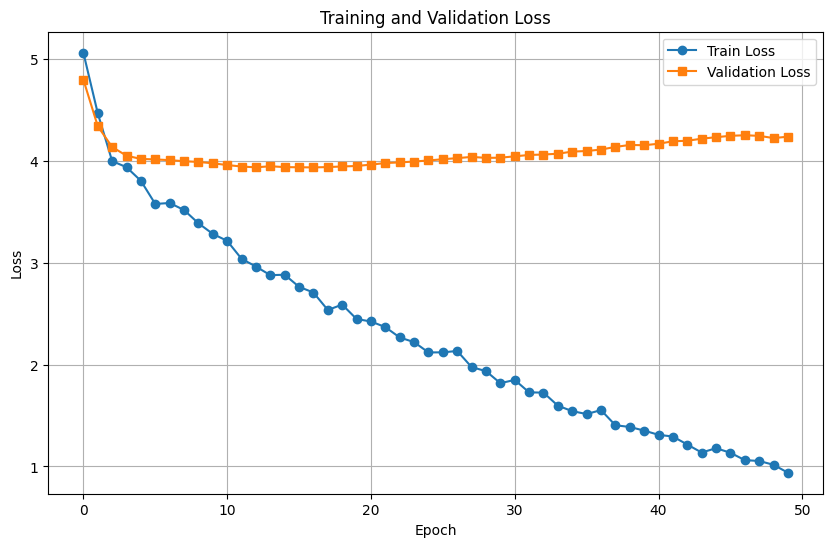

학습이 잘 수렴했는지 확인하세요!


In [23]:
# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 8️⃣ 번역 테스트

학습된 모델로 실제 번역을 해봅시다!

In [24]:
def greedy_decode(model, src, src_tokenizer, tgt_tokenizer, device, max_len=50):
    model.eval()

    with torch.no_grad():
        src_mask = model.make_src_mask(src)
        enc_output = model.encode(src, src_mask)

        tgt_indices = [tgt_tokenizer.word2idx[tgt_tokenizer.SOS_TOKEN]]

        for _ in range(max_len):
            tgt_tensor = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)
            tgt_mask = model.make_tgt_mask(tgt_tensor)

            dec_output = model.decode(tgt_tensor, enc_output, src_mask, tgt_mask)
            output = model.fc_out(dec_output)
            pred_token = output.argmax(dim=-1)[:, -1].item()

            tgt_indices.append(pred_token)

            if pred_token == tgt_tokenizer.word2idx[tgt_tokenizer.EOS_TOKEN]:
                break

        translated_sentence = tgt_tokenizer.decode(tgt_indices)
        return translated_sentence


def translate_sentence(sentence, model, src_tokenizer, tgt_tokenizer, device, max_len=50):
    """영어 문장을 한글로 번역"""
    src_indices = src_tokenizer.encode(sentence)

    if len(src_indices) > max_len:
        src_indices = src_indices[:max_len]
    else:
        src_indices = src_indices + [src_tokenizer.word2idx[src_tokenizer.PAD_TOKEN]] * (max_len - len(src_indices))

    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)
    translation = greedy_decode(model, src_tensor, src_tokenizer, tgt_tokenizer, device, max_len)

    return translation

print("✓ 번역 함수 로드 완료")

✓ 번역 함수 로드 완료


In [25]:
print("번역 예시")
print("=" * 70)

test_sentences = [
    "Hello",
    "Good morning",
    "Thank you",
    "I love you",
    "How are you",
    "I am happy",
    "The weather is good",
    "I like coffee",
    "Nice to meet you",
    "See you later"
]

for sentence in test_sentences:
    translation = translate_sentence(sentence, model, src_tokenizer, tgt_tokenizer, device)
    print(f"영어: {sentence}")
    print(f"번역: {translation}")
    print("-" * 70)

번역 예시
영어: Hello
번역: 안녕하세요
----------------------------------------------------------------------
영어: Good morning
번역: 좋은 아침입니다
----------------------------------------------------------------------
영어: Thank you
번역: 감사합니다
----------------------------------------------------------------------
영어: I love you
번역: 사랑해요
----------------------------------------------------------------------
영어: How are you
번역: 어떻게 지내세요
----------------------------------------------------------------------
영어: I am happy
번역: 저는 행복해요
----------------------------------------------------------------------
영어: The weather is good
번역: 날씨가 좋아요
----------------------------------------------------------------------
영어: I like coffee
번역: 저는 커피를 좋아해요
----------------------------------------------------------------------
영어: Nice to meet you
번역: 만나서 반가워요
----------------------------------------------------------------------
영어: See you later
번역: 나중에 봐요
--------------------------------------------------------------------

## 9️⃣ 직접 번역해보기

원하는 영어 문장을 입력해서 번역해보세요!

In [30]:
# 여기에 번역하고 싶은 영어 문장을 입력하세요
my_sentence = "Hello"  # 이 부분을 수정하세요

translation = translate_sentence(my_sentence, model, src_tokenizer, tgt_tokenizer, device)
print(f"영어: {my_sentence}")
print(f"번역: {translation}")

영어: Hello
번역: 안녕하세요
